In [107]:
import math

import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from nltk import tokenize
from tqdm.notebook import tqdm

from pan20 import fake, util
from pan20.util import ctree, lexical_negation, noble, sentiwordnet

In [4]:
df = fake.load()

In [5]:
df.head()

,author,tweet,label
0,f4zgi7ym7829iqld6x77q6mh30s0rf86,"Thanks ""ArtistRack"" For Following Me !!! #URL#",0
1,f4zgi7ym7829iqld6x77q6mh30s0rf86,"Thanks ""Sally Mansfield"" For Following Me !!! ...",0
2,f4zgi7ym7829iqld6x77q6mh30s0rf86,"Thanks ""Simão"" For Following Me !!! #URL#",0
3,f4zgi7ym7829iqld6x77q6mh30s0rf86,"RT BBCWorld ""Danish prince refuses to be burie...",0
4,f4zgi7ym7829iqld6x77q6mh30s0rf86,"RT Reuters ""Bieber says he's 'never going to b...",0


In [24]:
def plot_mu_std(pdf, attr, group=True, std=True):
    if group:
        mdf = pdf.groupby(['author', 'label']).mean().reset_index()
    else:
        mdf = pdf
    sns.distplot(mdf[mdf.label == 0][attr], label='Not Spreader')
    sns.distplot(mdf[mdf.label == 1][attr], label='Spreader')
    plt.legend()
    plt.title(f'Distributions of means of {attr}')
    plt.show()
    if std:
        if group:
            sdf = pdf.groupby(['author', 'label']).std().reset_index()
        else:
            sdf = pdf
        sns.distplot(sdf[sdf.label == 0][attr], label='Not Spreader')
        sns.distplot(sdf[sdf.label == 1][attr], label='Spreader')
        plt.legend()
        plt.title(f'Distributions of stds of {attr}')
        plt.show()

## RT Freq.

Concerned it won't generalize, though. Issue being last 100 tweets might not be stable enough of a sample.

In [6]:
df['rt'] = df.tweet.apply(util.is_retweet)

In [7]:
rt_freqs = df.groupby(['author', 'label']).mean().reset_index()

In [8]:
rt_freqs.groupby(['label']).mean().rt

label
0    0.154533
1    0.072333
Name: rt, dtype: float64

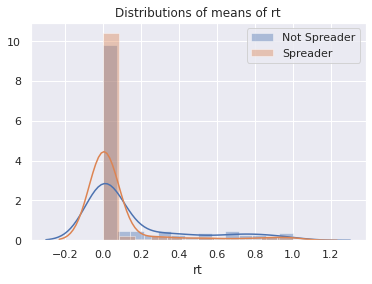

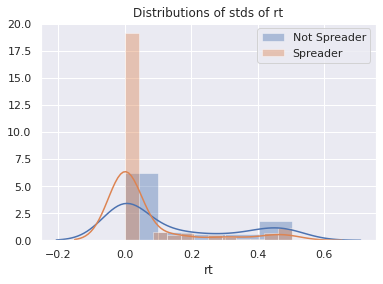

In [40]:
plot_mu_std(df, 'rt')

Not sure how much stock I want to put into this feature, or what it would really mean.

## Function Word Freq

In [10]:
fn = noble.CatFreqs()

In [11]:
freqs = []
with tqdm(total=len(df)) as pbar:
    for _, x in df.iterrows():
        freqs.append(fn(x.tweet))
        pbar.update()
print(len(freqs))


30000


In [12]:
for cat in noble.cats:
    df[cat] = [f[cat] for f in freqs]
df['n'] = [f['n'] for f in freqs]
df['function_words'] = [f['function_words'] for f in freqs]

In [14]:
df.to_csv('data/fake/feats.csv')

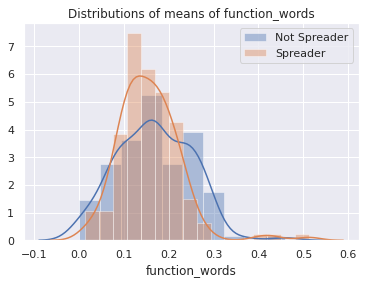

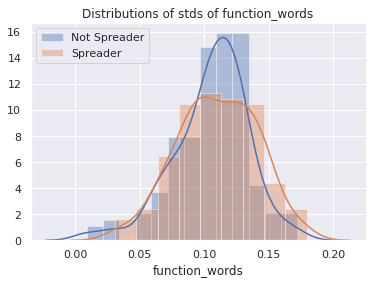

In [38]:
plot_mu_std(df, 'function_words')

## Constituency Tree Features

In [16]:
get_tree = ctree.GetTree()

In [20]:
trees = []
with tqdm(total=len(df)) as pbar:
    for _, x in df.iterrows():
        trees.append(get_tree(x.tweet))
        pbar.update()

Feats:
- branching factor
- height
- max NP height
- max PP height
- max VP height

In [27]:
df['avg_bf'] = [ctree.avg_branch_factor(t) for t in trees]
df['height'] = [t.height() for t in trees]
df['max_np_height'] = [ctree.max_const_height(t, 'NP') for t in trees]
df['max_pp_height'] = [ctree.max_const_height(t, 'PP') for t in trees]
df['max_vp_height'] = [ctree.max_const_height(t, 'VP') for t in trees]

In [39]:
df.to_csv('data/fake/feats.csv')

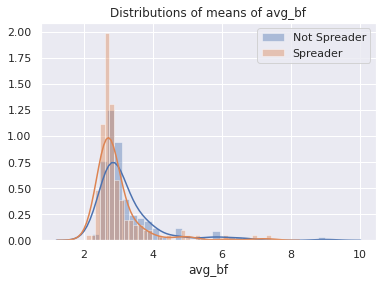

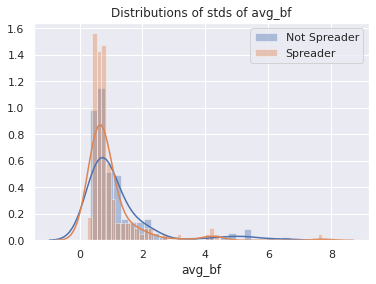

In [33]:
plot_mu_std(df, 'avg_bf')

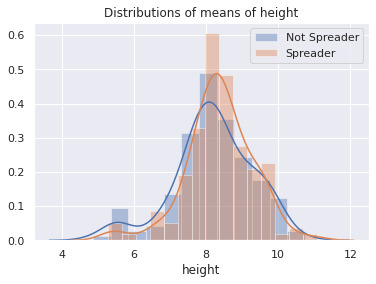

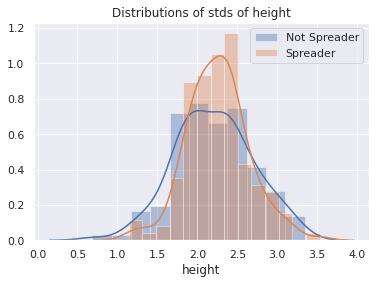

In [34]:
plot_mu_std(df, 'height')

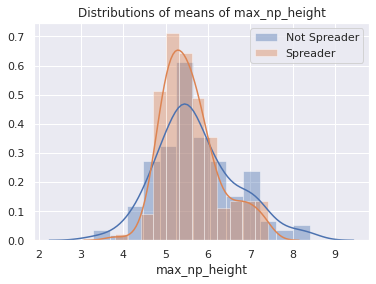

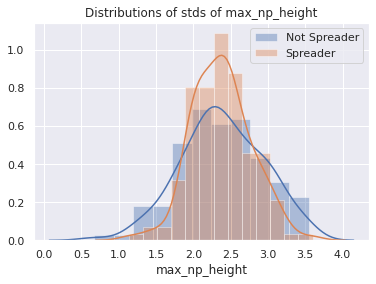

In [35]:
plot_mu_std(df, 'max_np_height')

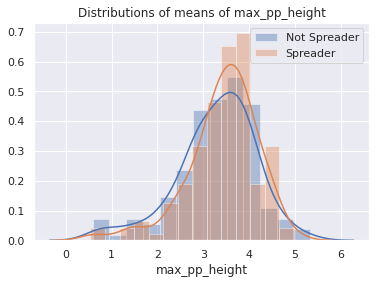

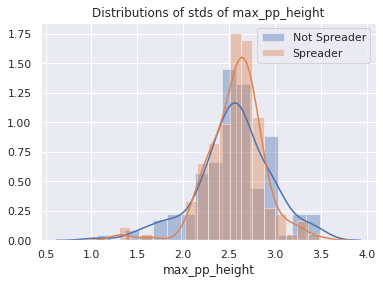

In [36]:
plot_mu_std(df, 'max_pp_height')

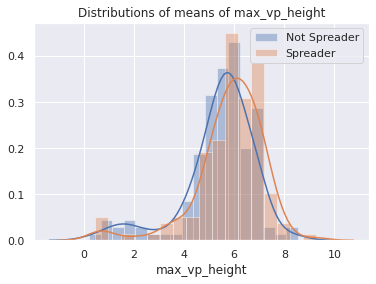

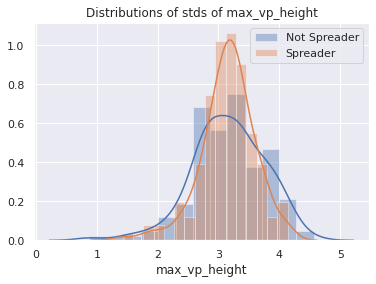

In [37]:
plot_mu_std(df, 'max_vp_height')

## Punctuation

In [41]:
import string

print(len(string.punctuation))
print(string.punctuation)

32
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


The only psychologically meaningful one I think is `!`.

In [48]:
df['exclaims'] = df.tweet.apply(lambda x: sum(1 for c in x if c == '!') / len(x))

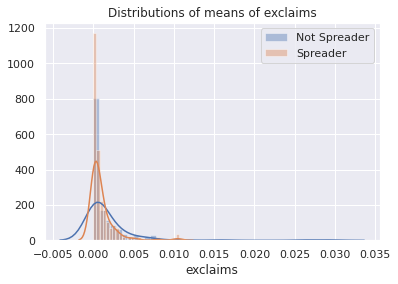

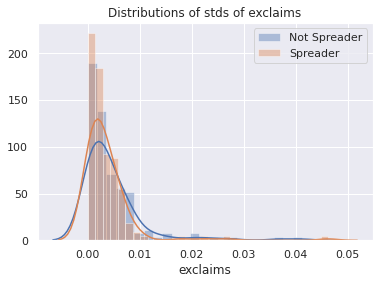

In [49]:
plot_mu_std(df, 'exclaims')

In [ ]:
df.to_csv('data/fake/feats.csv')

In [2]:
df = pd.read_csv('data/fake/feats.csv')

## LIWC

In [11]:
liwc_out = pd.read_csv('data/fake/liwc_out.csv')
liwc_out = liwc_out[liwc_out.Filename != 'author.txt']

In [5]:
truth = {x.author: x.label for _, x in df.groupby(['author', 'label']).mean().reset_index().iterrows()}

In [12]:
liwc_out['label'] = liwc_out.Filename.apply(lambda x: truth[x.split('.')[0]])

In [14]:
liwc_out.head()

,Filename,Segment,WC,Analytic,Clout,Authentic,Tone,function,pronoun,ppron,...,anger,sad,cogproc,insight,cause,discrep,tentat,certain,differ,label
0,06ct0t68y1acizh9eow3g5rhancrppr8.txt,1,2057,92.80,83.34,11.54,68.00,30.09,5.64,3.31,...,1.02,0.34,5.79,1.80,1.26,0.24,0.97,0.83,0.92,1
1,071nxc49ihpd0jlfmvn2lghtayy3b5n9.txt,1,1348,94.82,87.34,4.88,40.44,26.78,4.97,3.86,...,0.52,0.52,4.82,0.96,1.26,0.37,0.59,1.04,0.74,0
2,09py5qescynpnnckmzueqzr2y49moh1o.txt,1,1540,91.11,86.24,4.24,58.95,23.51,4.74,2.86,...,0.39,0.13,3.57,0.71,1.10,0.19,0.78,0.65,0.39,0
3,0dwovd7nj6yg9m795ng2c629me0ccmrh.txt,1,282,99.00,52.84,7.63,1.30,25.53,0.71,0.35,...,1.06,1.77,2.48,1.42,0.00,0.35,0.71,0.35,0.35,0
4,0ibi364m7i7l01xi4xqafyathrmrrnll.txt,1,890,94.33,58.87,3.94,2.97,21.35,2.25,1.35,...,2.47,0.00,4.94,0.56,2.13,0.45,0.45,0.67,1.01,1


19


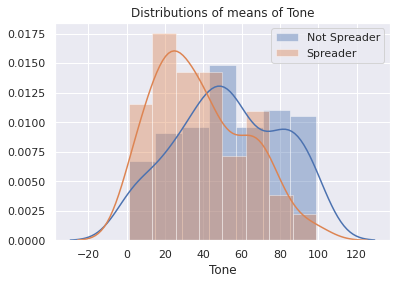

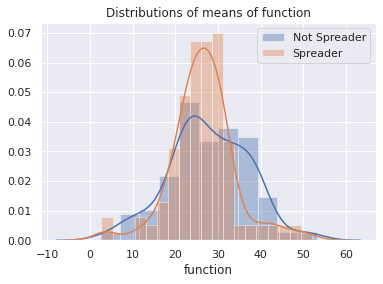

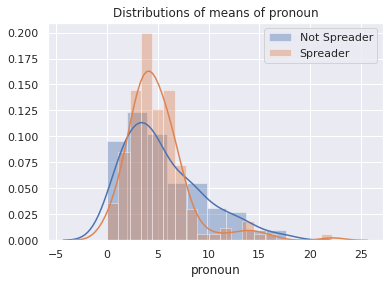

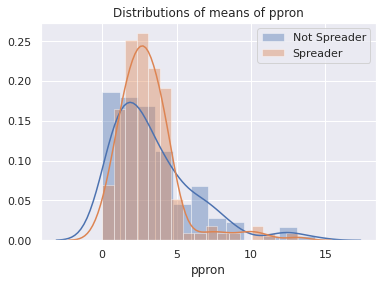

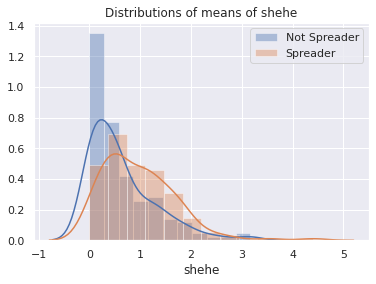

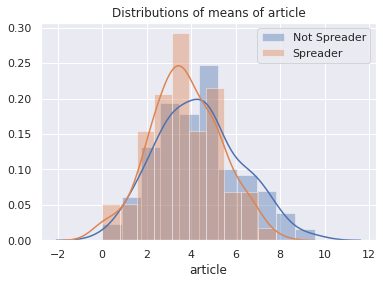

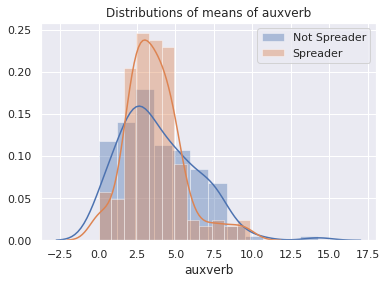

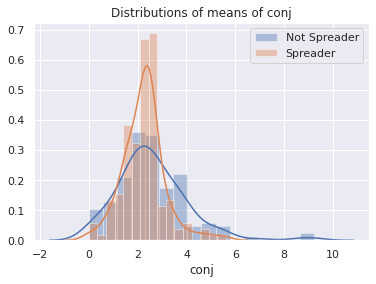

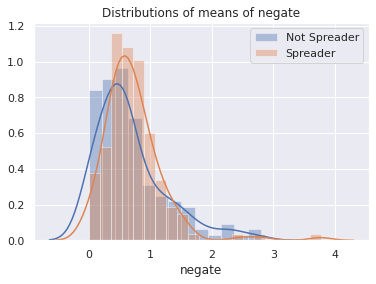

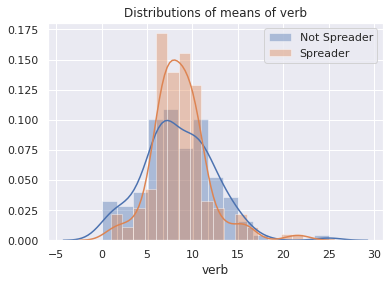

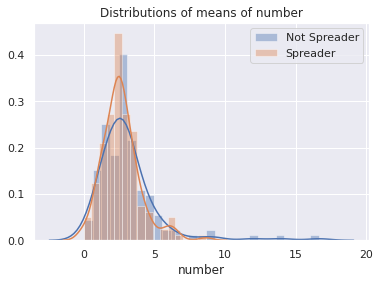

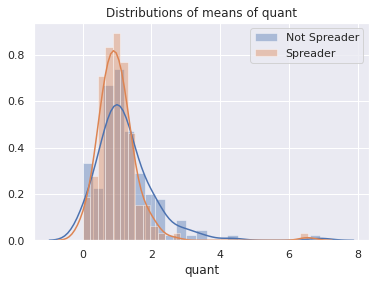

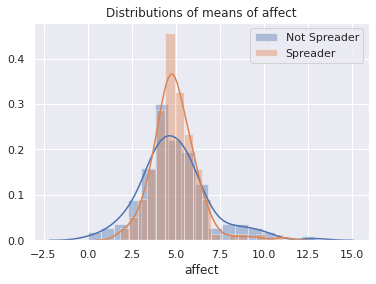

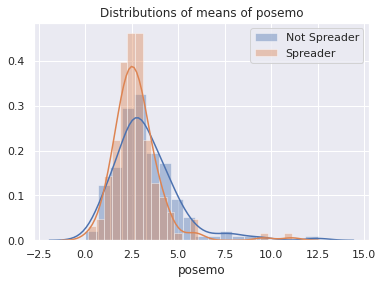

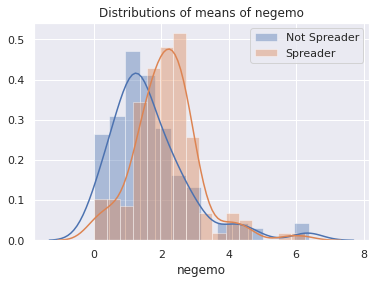

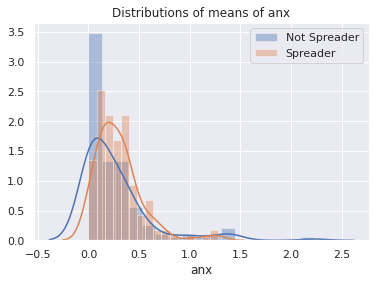

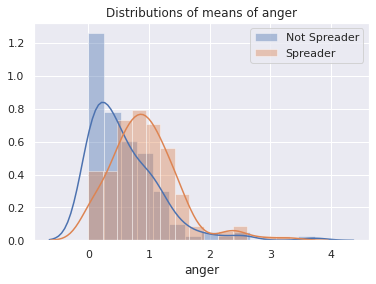

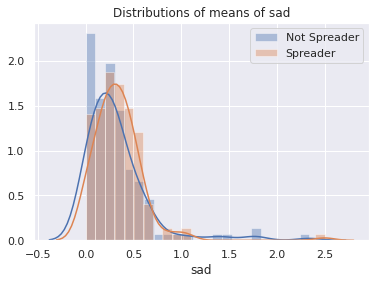

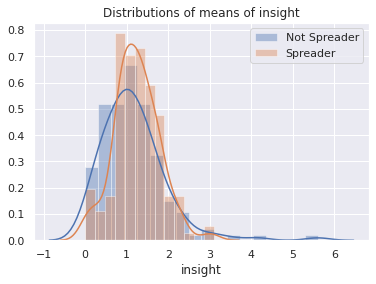

In [89]:
# posthoc list
unwanted = [
    'WC', 'Filename', 'Segment', 'label',
    'Analytic', 'Clout', 'Authentic',
    'i', 'you', 'we', 'they', 'ipron',
    'prep', 'adverb', 'differ', 'tentat',
    'discrep', 'adj', 'compare', 'interrog',
    'cogproc', 'cause', 'certain',
]
targets = [c for c in liwc_out.columns if c not in unwanted]
print(len(targets))
for target in targets:
    plot_mu_std(liwc_out, target, False, False)

## Open Source Pos-Neg Lexicon: SentiWordNet

In [72]:
swn = sentiwordnet.SentiWordNet()

In [55]:
df['toks'] = df.tweet.apply(lambda x: tokenize.word_tokenize(x))

In [73]:
df['senti'] = df.toks.apply(swn.score)
df['senti_neg'] = df.toks.apply(swn.score_neg)
df['senti_pos'] = df.toks.apply(swn.score_pos)

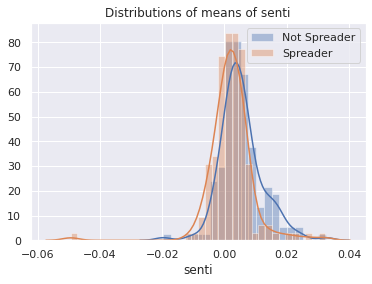

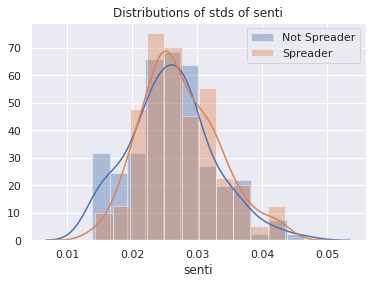

In [74]:
plot_mu_std(df, 'senti')

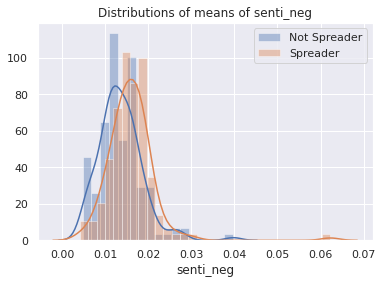

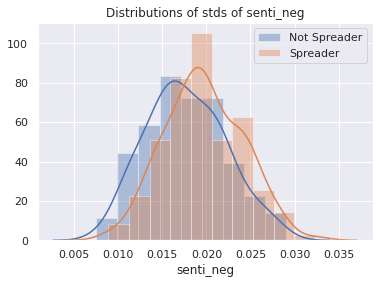

In [75]:
plot_mu_std(df, 'senti_neg')

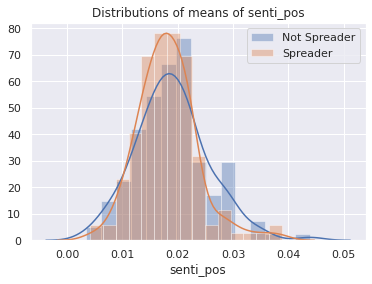

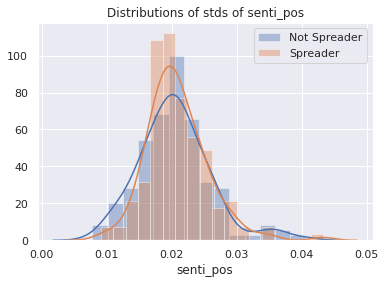

In [76]:
plot_mu_std(df, 'senti_pos')

Doesn't seem to be as good of a feature as LIWC, but it is some of the way. Here we have sentiment words, but I think they use more psychologically motivated words, ones that perhaps represent a psychological state as opposed to a negative judgment. It would be valuable to look at more psycho-linguistic stuff in this respect, to find a better profile.

## Open Source Negation

This feature looked pretty good from the LIWC analysis.

In [79]:
negations = ['n\'t', 'no', 'not', 'never', 'nowhere', 'nobody']

In [80]:
# first step is to simply use that quick custom list
df['negate'] = df.toks.apply(lambda x: sum(1 for t in x if t in negations) / len(x))

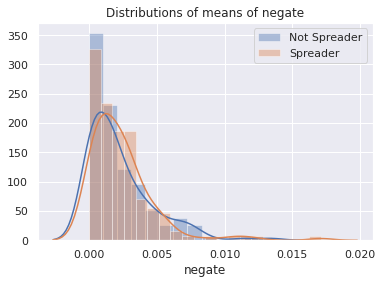

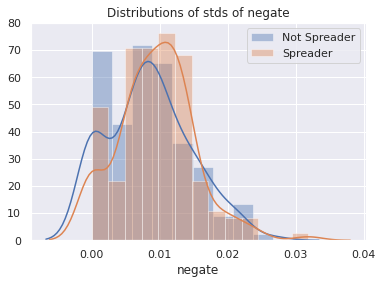

In [81]:
plot_mu_std(df, 'negate')

Let's add the lexical negation dict.

In [95]:
ln = lexical_negation.LexicalNegations()

In [96]:
df['ln_pos'] = df.toks.apply(lambda x: sum(t in ln.pos for t in x) / len(x))
df['ln_neg'] = df.toks.apply(lambda x: sum(t in ln.neg for t in x) / len(x))

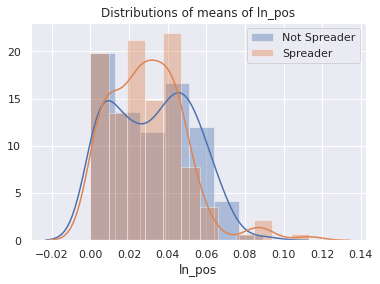

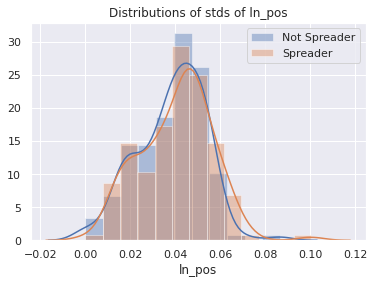

In [97]:
plot_mu_std(df, 'ln_pos')

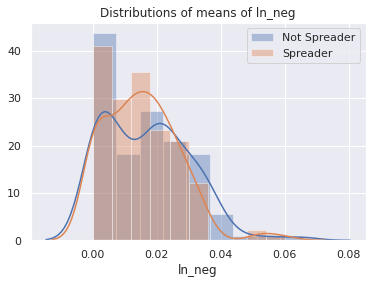

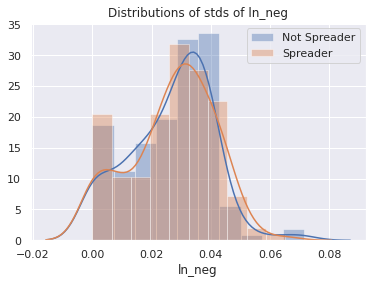

In [98]:
plot_mu_std(df, 'ln_neg')

## Articles

LIWC indicated interesting, also have a psychological interpretation: concreteness.

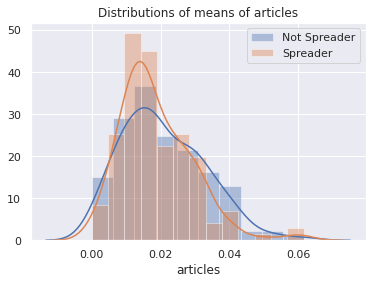

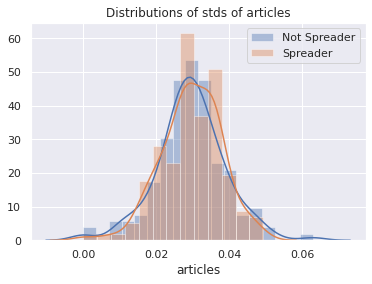

In [101]:
plot_mu_std(df, 'articles')

Pretty close to the same as LIWC.

## VERB freqs

The LIWC analysis indicated perhaps verb usage rates are different.

In [125]:
preds = [
    {'author': 'abc', 'pred': 1},
    {'author': 'def', 'pred': 1},
]
outputs.save(preds)

In [113]:
df['pos'] = df.toks.apply(lambda x: [t[1] for t in nltk.pos_tag(x)])

In [121]:
verb_pos = ['VB', 'VBP', 'VBN', 'VBZ', 'VBG']

def verb_freq(pos):
    return sum(1 for p in pos if p in verb_pos) / len(pos)

df['verb_freq'] = df.pos.apply(verb_freq)

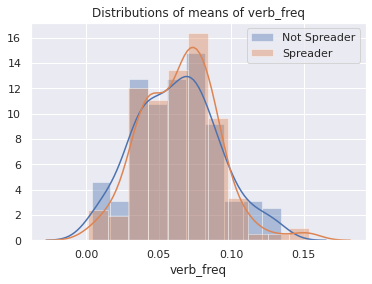

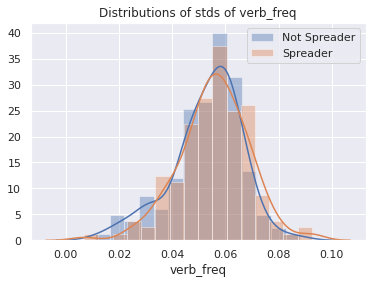

In [122]:
plot_mu_std(df, 'verb_freq')

Not looking as good as LIWC.

## Number and Quant

Also from LIWC analysis.

## Negemo - different from negative sentiment

## Anger words

## Anxiety words

- Commercial stuff in the positive cases?
- Use of emoji?

In [78]:
for _, x in df.sample(40).iterrows():
    print('-' * 8)
    print(x.label)
    print('  '.join(x.toks))

--------
0
Do  n't  ever  be  broke  and  fat  ,  it  's  so  annoying  cause  you  keep  disappointing  people  Hustle  And  bustle  Nwanne
--------
1
OnePlus  5T  will  be  released  next  week  in  a  new  limited-edition  color  #  URL  #
--------
0
Harvey  Weinstein  Takes  Leave  Of  Absence  After  New  York  Times  Expose  Blows  The  Lid  Off  Decades  Of  Sexual  Harassment  :  …  #  URL  #
--------
0
RT  #  USER  #  :  Leaving  your  little  one  overnight  can  be  super  emotional  .  Check  out  some  tips  from  #  USER  #  to  help  you  with  your  fi…
--------
1
Taylor  Swift  's  Grammy  Evolution  :  A  Look  Back  at  Her  Award  Show  Style  #  URL  #  #  URL  #
--------
1
Feds  Blame  De  Blasio  For  Murder  Of  92-Year-Old  Woman  By  Illegal  Immigrant  #  URL  #
--------
0
Emma  Watson  's  Doppelgänger  Will  Make  You  Think  Your  Eyes  Are  Playing  Tricks  :  Instagram  user  Megan  Flockhart  i  ...  #  URL  #
--------
1
Donald  Trump  and  Benjamin  Ne

b